# Homework 4
## DSE 220: Machine Learning
## Due Date: 26 May 2017
## Orysya Stus

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Overview
The large number of English words can make language-based applications daunting. To cope with this, it is helpful to have a clustering or embedding of these words, so that words with similar meanings are clustered together, or have embedding that are close to one another. 

But how can we get at the meanings of words? John Firth (1957) put it thus:
You shall know a word by the company it keeps.

That is, words that tend to appear in similar contexts are likely to be related. In this assignment, you will investigate this idea by coming up with an embedding of words that is based on co-occurrence statistics.

The description here assumes you are using Python with NLTK.

1.First, download the Brown corpus (using nltk.corpus). This is a collection of text samples from a wide range of sources, with a total of over a million words. Calling brown.words() returns this text in one long list, which is useful.

http://www.nltk.org/book/ch02.html

In [16]:
from nltk.corpus import brown
word_list = brown.words()
print('There are', len(word_list), 'words in the Brown corpus.')

There are 1161192 words in the Brown corpus.


2.Remove stopwords and punctuation, make everything lowercase, and count how often each word occurs. Use this to come up with two lists:

    A vocabulary V , consisting of a few thousand (e.g., 5000) of the most commonly-occurring words.
    
    A shorter list C of at most 1000 of the most commonly-occurring words, which we shall call context words.

In [17]:
from nltk.corpus import stopwords
import string
word_list = [''.join(c for c in s if c not in string.punctuation) for s in word_list]
word_list = [w.lower() for w in word_list if w != '']
print ('There are', len(word_list), 'words when punctuation is removed.')
word_list = [word for word in word_list if word not in stopwords.words('english')]
print ('There are', len(word_list), 'words when stopwords are removed.')

There are 1013319 words when punctuation is removed.
There are 539921 words when stopwords are removed.


In [59]:
import operator
Dict = {}
def freq_counter(List):
    for w in List:
        if w in Dict.keys():
            Dict[w]+=1
        else:
            Dict[w]=1
freq_counter(word_list)
sorted_counts = sorted(Dict.items(), key=operator.itemgetter(1), reverse=True)

In [60]:
V = [x[0] for x in sorted_counts[:5000]]
C = [x[0] for x in sorted_counts[:1000]]

3.For each word w 2 V , and each occurrence of it in the text stream, look at the surrounding window of four words (two before, two after):
        w1 w2 w w3 w4:
        
Keep count of how often context words from C appear in these positions around word w. That is, for w 2 V , c 2 C, define n(w; c) = # of times c occurs in a window around w:

Using these counts, construct the probability distribution Pr(cjw) of context words around w (for each winV ), as well as the overall distribution Pr(c) of context words. These are distributions over C.

In [418]:
# def compute_kmers(wordlist,k):
#     kmers = []
#     for i in range(len(wordlist)+1-k):
#         kmer = wordlist[i:i+k]
#         kmers.append(kmer)            
#     return kmers
# kmers = compute_kmers(word_list, 5)

In [419]:
# winV = []
# for w in V:
#     for i in range(len(kmers)):
#         if w == kmers[i][2]:
#             winV.append(kmers[i])
#         else:
#             pass
# winV

In [420]:
# Pr_cw = pd.DataFrame(0, index=V, columns=C)
# for i in range(len(winV)):
#     V_index = Pr_cw.index[winV[i][2] == Pr_cw.index]
#     data = winV[i][:2] + winV[i][3:]
#     for d in data:
#         if d in C:
#             Pr_cw.ix[V_index, d] += 1
#         else:
#             pass
# Pr_cw

In [291]:
# import itertools
# VC_crossprod = {key: 0 for key in itertools.product(V, C)}

In [421]:
# for key, value in VC_crossprod.items():
#     for i in range(len(winV)):
#         if key[0] == winV[i][2]:
#             words = winV[i][:2] + winV[i][3:]
#             count = words.count(key[1])
#             VC_crossprod[key] = VC_crossprod.get(key, value) + count

In [453]:
n_wc = np.zeros((5000, 1000))
for w in V:
    V_index = [i for i,val in enumerate(V) if val==w]
    kmers = []
    indices = [i for i,val in enumerate(word_list) if val==w]
    for i in indices:
        if i == 0:
            kmer = word_list[i+1:i+3]
        elif i == 1:
            kmer = word_list[i-1:i] + word_list[i+1:i+3]
        else:
            kmer = word_list[i-2:i] + word_list[i+1:i+3]
        kmers.append(kmer)
    for kmer in kmers:
        for word in kmer:
            if word in C:
                C_index = [i for i,val in enumerate(C) if val==word]
                n_wc[V_index, C_index] += 1
            else:
                pass

In [457]:
Pr_cw = n_wc/n_wc.sum(axis=1, keepdims=True)

In [458]:
c = n_wc.sum(axis=0)
total_Cs = c.sum()
Pr_c = c/total_Cs

In [459]:
df_Pr_cw = pd.DataFrame(Pr_cw, index=V, columns=C)

4.Represent each vocabulary item w by a |C|-dimensional vector phi(w), whose c'th coordinate is:

phi(w) = max(0; log(Pr(cjw)/Pr(c)))

This is known as the (positive) pointwise mutual information, and has been quite successful in work on word embedding.

In [479]:
phi_w = log(Pr_cw/Pr_c)
phi_w[phi_w < 0] = 0

C:\Users\Orysya\Anaconda\envs\py36\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


5.Suppose we want a 100-dimensional representation. How would you achieve this?

### DESCRIBE why used PCA

In [526]:
from sklearn.decomposition import PCA
df_phi_w = pd.DataFrame(phi_w, index=V, columns=C)
pca = PCA(n_components=100)
pca_phi_w = pca.fit_transform(phi_w)
pca_phi_w = pd.DataFrame(pca_phi_w, index=V)
print('For PCA(100), ', np.sum(pca.explained_variance_ratio_)* 100.0, '% of the variance is explained.')

For PCA(100),  22.5419203625 % of the variance is explained.


6.Investigate the resulting embedding in two ways:
    
     Cluster the vocabulary into 100 clusters. Look them over; do they seem completely random, or is there some sense to them?
     Try finding the nearest neighbor of selected words. Do the answers make sense?

In [ ]:
# from sklearn.cluster import KMeans

# iters = range(100)
# inertias = []
# for i in iters:
#     k_means = KMeans(n_clusters=100, max_iter = i, init='random')
#     k_means.fit(X)
#     inertias.append(k_means.inertia_)  

In [654]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100, max_iter= 1000, random_state=0).fit(pca_phi_w)
grouping = {i:[] for i in range(0,100)}

for i,w in enumerate(V):
    grouping[kmeans.labels_[i]].append(w)

In [655]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,20

In [656]:
from scipy.cluster.hierarchy import dendrogram, linkage

def cluster_nearest_neighbor(cluster_index):
    cluster = grouping[cluster_index]
    print('For grouping', cluster_index, 'the words in the cluster are: \n', cluster)
    indices = []
    for word in cluster:
        ind = [i for i,val in enumerate(pca_phi_w.index) if val==word][0]
        indices.append(ind) 
    subset = pca_phi_w.ix[indices]
    classes = subset.index
    Z = linkage(subset, 'ward')
    
    plt.title('Hierarchical Clustering of Cluster Words')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(Z, labels= classes, orientation='right')
    plt.show()

For grouping 2 the words in the cluster are: 
 ['water', 'light', 'body', 'air', 'ground', 'floor', 'earth', 'carried', 'sun', 'heavy', 'covered', 'built', 'filled', 'rose', 'frame', 'rain', 'dust', 'walls', 'soft', 'cool', 'roof', 'flying', 'height']


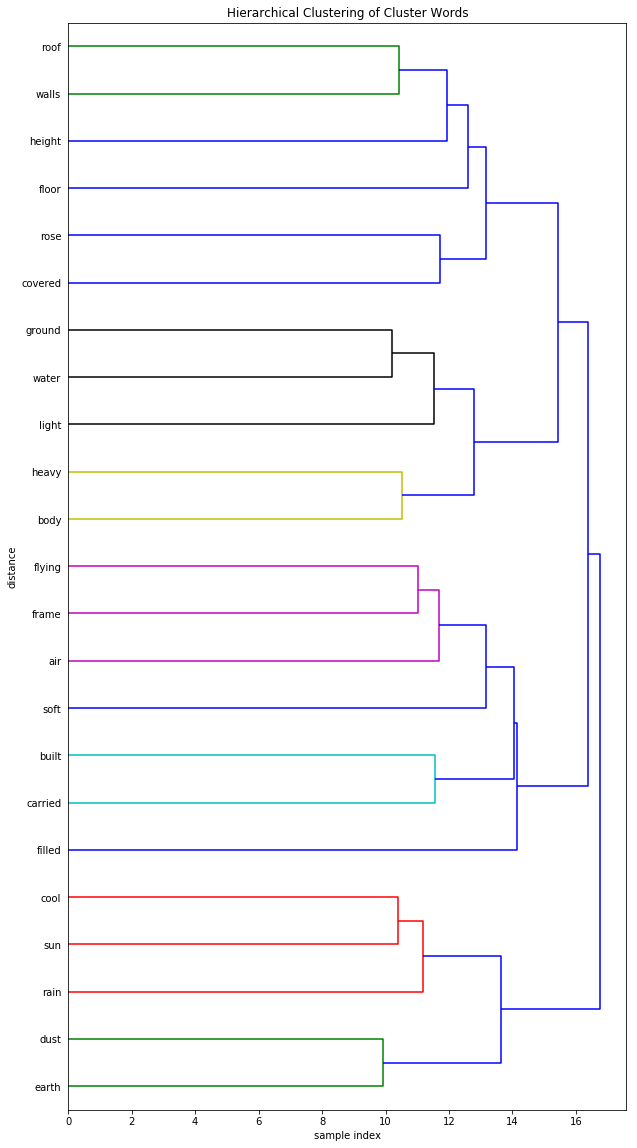

In [657]:
cluster_nearest_neighbor(2)

In [659]:
from sklearn.neighbors import NearestNeighbors

def knearest_neighbors(word_list):
    for word in word_list:
        subset = pca_phi_w.drop(word)
        neigh = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine')
        neigh.fit(subset)
        distance = neigh.kneighbors(pca_phi_w[pca_phi_w.index == word])[0]
        nearest_neighbor_index = neigh.kneighbors(pca_phi_w[pca_phi_w.index == word])[1]
        print('Word:', word, '-- Nearest neighbor:', pca_phi_w.index[nearest_neighbor_index][0][0], '-- Distance:', distance[0][0])

7.The Brown corpus is very small. Current work on word embedding uses data sets that are several orders of magnitude larger, but the methodology is along the same lines.

## What to Turn In

On the due date, turn in a typewritten report containing the following elements (each labeled clearly).

### 1. A description of your 100-dimensional embedding. 
The description should be concise and clear, and should make it obvious exactly what steps you took to obtain your word embeddings. Below, we will denote these as Ψ(w) ∈ R100, for w ∈ V . Also clarify exactly how you selected the vocabulary V and the context words C.

### 2. Nearest neighbor results.
Pick a collection of 25 words w ∈ V . For each w, return its nearest neighbor w' != w in V. A popular distance measure to use for this is cosine distance:

1 − (Ψ(w).Ψ(w'))/ (||Ψ(w)|| ||Ψ(w')||)

Here are some suggestions for words you might choose:
communism, autumn, cigarette, pulmonary, mankind, africa, chicago, revolution, september, chemical, detergent, dictionary, storm, worship

Do the results make any sense? You can use other distance measures apart from cosine distance to improve the results.

In [653]:
words = ['communism', 'autumn', 'cigarette', 'pulmonary', 'mankind', 'africa', 'chicago', 'revolution', 'september', 'chemical', 'detergent', 'dictionary', 'storm', 'worship']
knearest_neighbors(words)

Word: communism -- Nearest neighbor: decline -- Distance: 0.610159837146
Word: autumn -- Nearest neighbor: journey -- Distance: 0.496393118305
Word: cigarette -- Nearest neighbor: lighted -- Distance: 0.486430360111
Word: pulmonary -- Nearest neighbor: artery -- Distance: 0.262623634083
Word: mankind -- Nearest neighbor: chances -- Distance: 0.591713952975
Word: africa -- Nearest neighbor: opinions -- Distance: 0.308037722144
Word: chicago -- Nearest neighbor: preliminary -- Distance: 0.462430459092
Word: revolution -- Nearest neighbor: century -- Distance: 0.619241837623
Word: september -- Nearest neighbor: june -- Distance: 0.245003876174
Word: chemical -- Nearest neighbor: mold -- Distance: 0.458456897885
Word: detergent -- Nearest neighbor: fabrics -- Distance: 0.486990209937
Word: dictionary -- Nearest neighbor: text -- Distance: 0.311639743114
Word: storm -- Nearest neighbor: saturday -- Distance: 0.502350485984
Word: worship -- Nearest neighbor: environment -- Distance: 0.560869

### 3. Clustering.
Using the vectorial representation Ψ(.), cluster the words in V into 100 groups. Clearly specify what algorithm and distance function you using for this, and the reasons for your choices.

Look over the resulting 100 clusters. Do any of them seem even moderately coherent? Pick out a few of the best clusters and list the words in them.

In [ ]:
grouping